<a href="https://colab.research.google.com/github/AmiraBelkis/PFE-TEST/blob/Final-Test/Cifar-10/AG_ResNet18_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rssrc

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Aug  1 11:14:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Lib

In [2]:
import random
import string
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import matplotlib.colors as colors
import numpy as np
from copy import deepcopy

In [3]:
import AG

100%|██████████| 170498071/170498071 [00:02<00:00, 76217985.98it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
import importlib
import global_param
importlib.reload(global_param)
importlib.reload(AG)

Files already downloaded and verified
Files already downloaded and verified


<module 'AG' from '/content/AG.py'>

# AG

In [5]:
model_path = '/content/drive/Shareddrives/PFE 22 23 Feliachi et Frioui/..Tests/Models/Cifar-10/resnet18_cifar_10'
model_base = torch.load(model_path)

In [ ]:
AG.evaluation_2(model_base , nn.CrossEntropyLoss())

Accuracy: 78.71%
Loss: 0.6449


(0.7871, 0.6449300147545566)

## Fine-tune the base model

In [ ]:
def train_model(model, criterion, optimizer, scheduler , num_epochs=7):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    statics = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in global_param.dataloaders[phase]:
                inputs = inputs.to(global_param.device)
                labels = labels.to(global_param.device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / global_param.dataset_sizes[phase]
            epoch_acc = running_corrects.double() / global_param.dataset_sizes[phase]
            statics.append(
                {'epoch': epoch+1, 'phase': phase, 'acc': epoch_acc, 'loss': epoch_loss}
            )
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, statics

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_base.parameters(), lr=0.002, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.1)
train_model(model_base, criterion , optimizer_conv , exp_lr_scheduler , 5)


Epoch 0/4
----------
train Loss: 0.2776 Acc: 0.9030
val Loss: 0.1893 Acc: 0.9340

Epoch 1/4
----------
train Loss: 0.1031 Acc: 0.9664
val Loss: 0.1648 Acc: 0.9425

Epoch 2/4
----------
train Loss: 0.0462 Acc: 0.9872
val Loss: 0.1534 Acc: 0.9488

Epoch 3/4
----------
train Loss: 0.0204 Acc: 0.9958
val Loss: 0.1564 Acc: 0.9504

Epoch 4/4
----------
train Loss: 0.0108 Acc: 0.9986
val Loss: 0.1574 Acc: 0.9513

Training complete in 19m 2s
Best val Acc: 0.951300


(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU

In [ ]:
torch.save(model_base,model_path)

In [6]:
AG.evaluation_2(model_base , nn.CrossEntropyLoss())

Accuracy: 95.13%
Loss: 0.1589


(0.9513, 0.15887547162165688)

## AG method

In [ ]:
save_to = '/content/drive/Shareddrives/PFE 22 23 Feliachi et Frioui/..Tests/Cifar-10/ResNet18/'
os.makedirs(save_to, exist_ok=True)
os.makedirs(save_to +'children/', exist_ok=True)
os.makedirs(save_to +'parents/', exist_ok=True)
os.makedirs(save_to +'kd/', exist_ok=True)
os.makedirs(save_to +'kd/training/', exist_ok=True)

Generating the initial population :
     - individual 0 ----------- 100%
     - individual 1 ----------- 100%
     - individual 2 ----------- 100%
     - individual 3 ----------- 100%
     - individual 4 ----------- 100%
     - individual 5 ----------- 100%
     - individual 6 ----------- 100%
     - individual 7 ----------- 100%
Performing KD on the initial population :
------------------------------ Training 1 ---------------------------------
Epoch 0/4
----------
train Loss: 2.4003 Acc: 0.3992
val Loss: 2.2232 Acc: 0.4990

Epoch 1/4
----------
train Loss: 1.9738 Acc: 0.6001
val Loss: 1.9071 Acc: 0.6144

Epoch 2/4
----------
train Loss: 1.7876 Acc: 0.6726
val Loss: 1.6921 Acc: 0.6953

Epoch 3/4
----------
train Loss: 1.6727 Acc: 0.7162
val Loss: 1.6163 Acc: 0.7191

Epoch 4/4
----------
train Loss: 1.5908 Acc: 0.7454
val Loss: 1.5531 Acc: 0.7388

Training complete in 22m 34s
Best val Acc: 0.738800
------------------------------ Training 2 ---------------------------------
Epoch 0/4
--

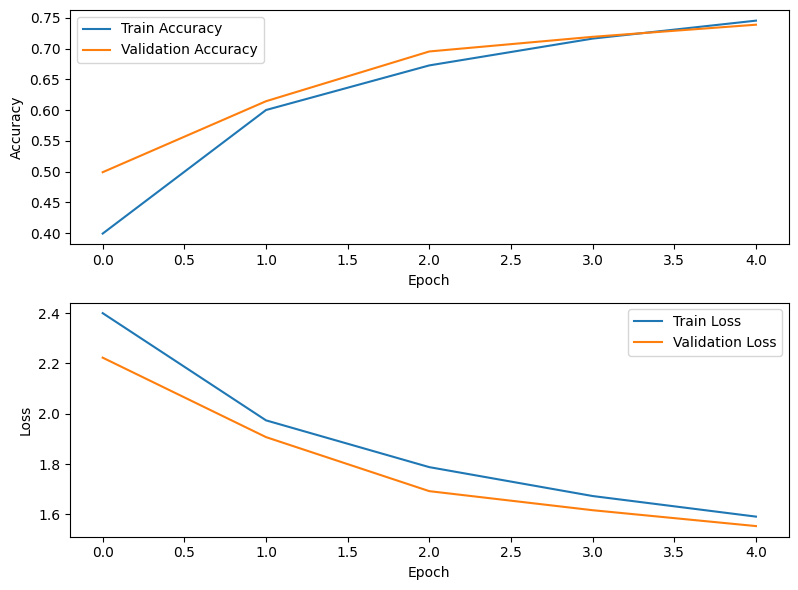

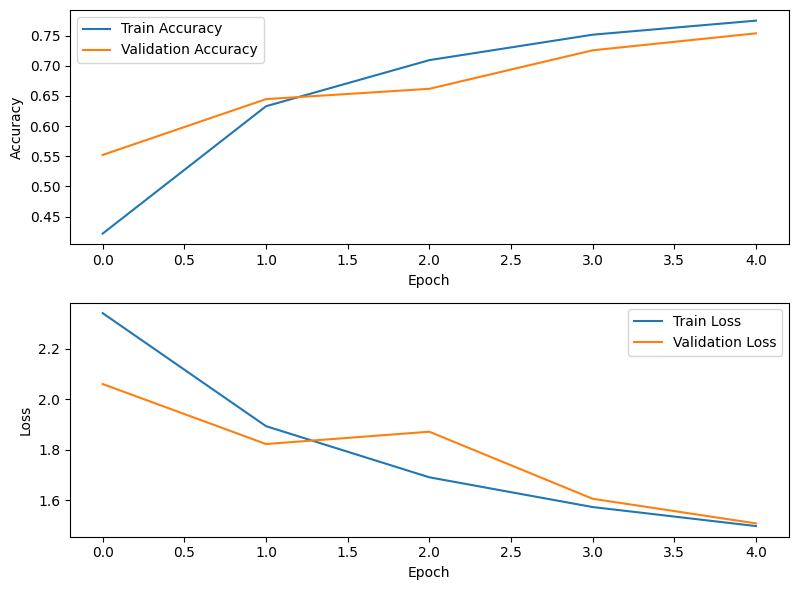

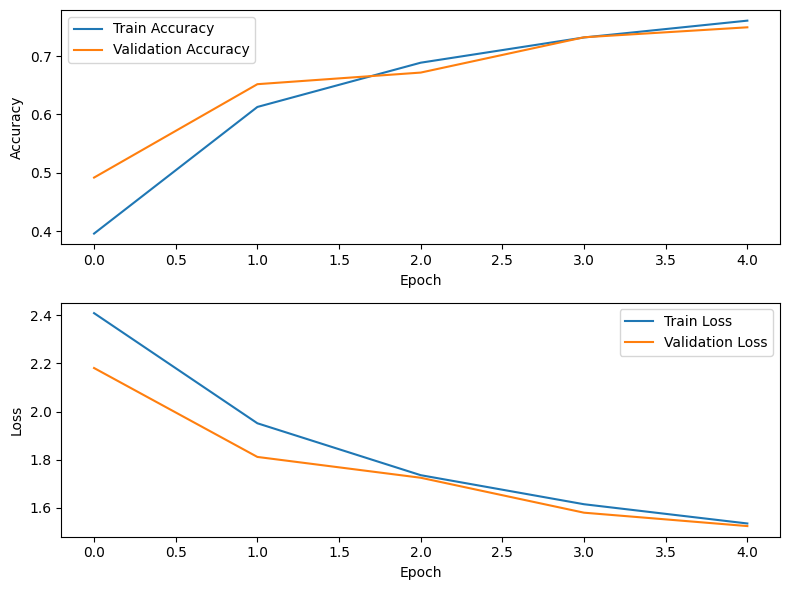

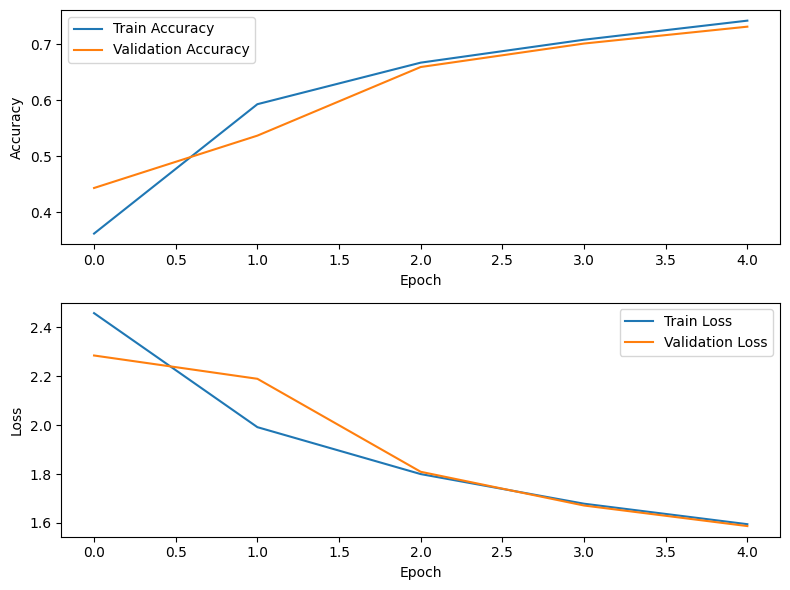

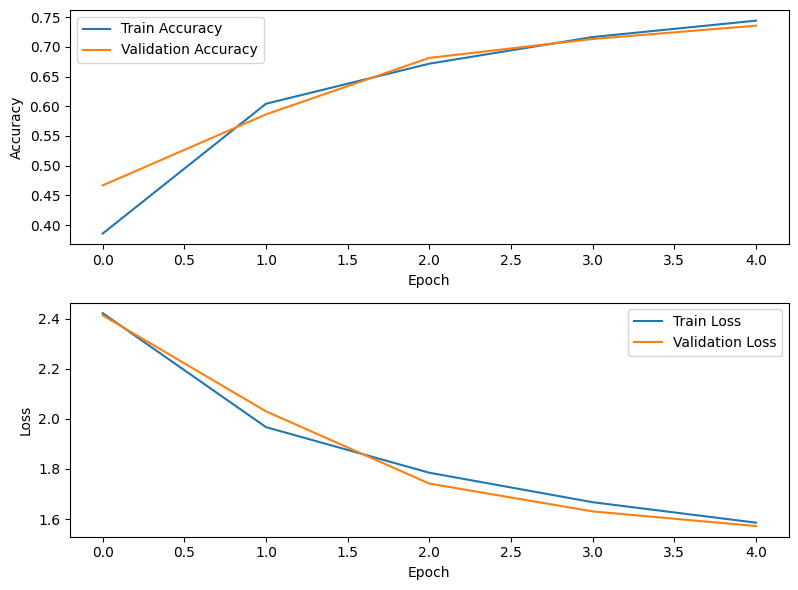

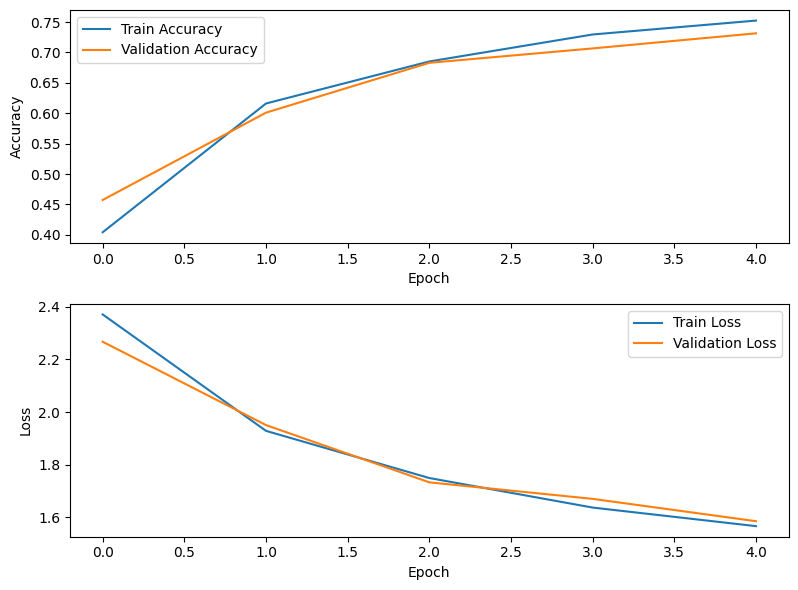

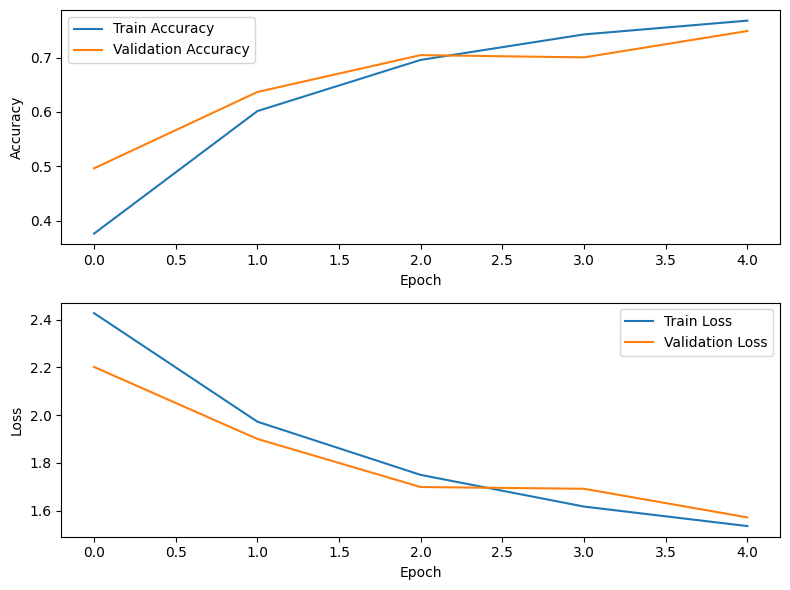

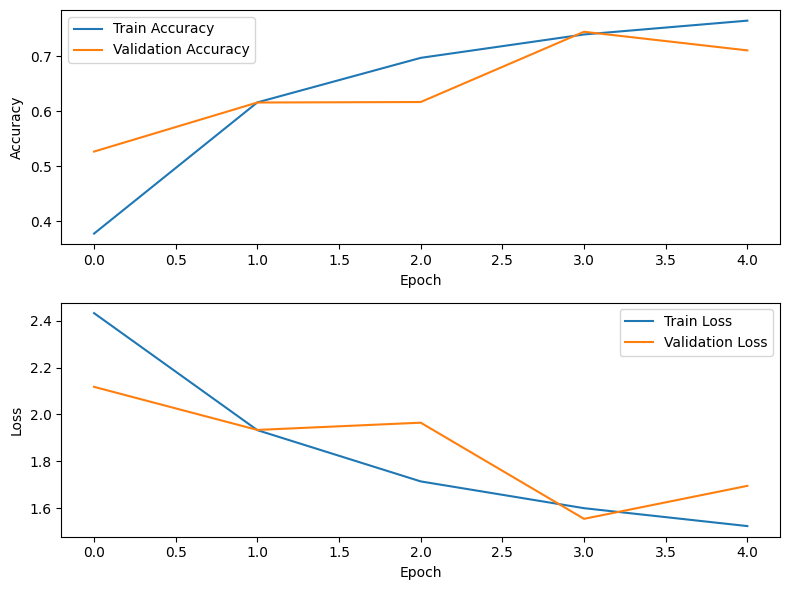

/*-----------------------------*/
/*         iteration 1        */
/*----------------------------*/
   * Select parent for crossing:
       - Selection --------------- 100%
   * Offspring:
       - Crossover:
           mask : [1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0]
       - Crossover:
           mask : [0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1]
       - Performing KD on the children :
------------------------------ Training 1 ---------------------------------
Epoch 0/4
----------
train Loss: 2.2827 Acc: 0.4618
val Loss: 2.0486 Acc: 0.5570

Epoch 1/4
----------
train Loss: 1.8792 Acc: 0.6379
val Loss: 1.7379 Acc: 0.6774

Epoch 2/4
----------
train Loss: 1.7067 Acc: 0.7017
val Loss: 1.7564 Acc: 0.6752

Epoch 3/4
----------
train Loss: 1.5986 Acc: 0.7391
val Loss: 1.5615 Acc: 0.7367

Epoch 4/4
----------
train Loss: 1.5318 Ac

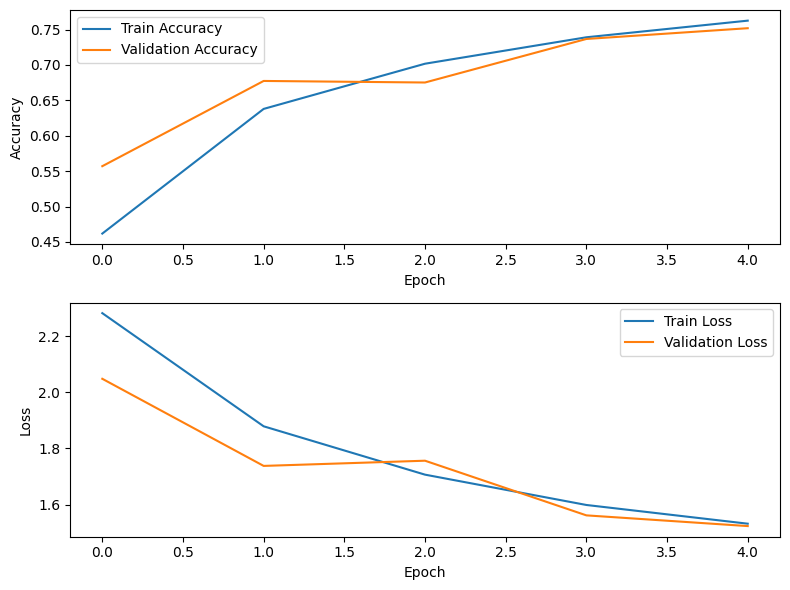

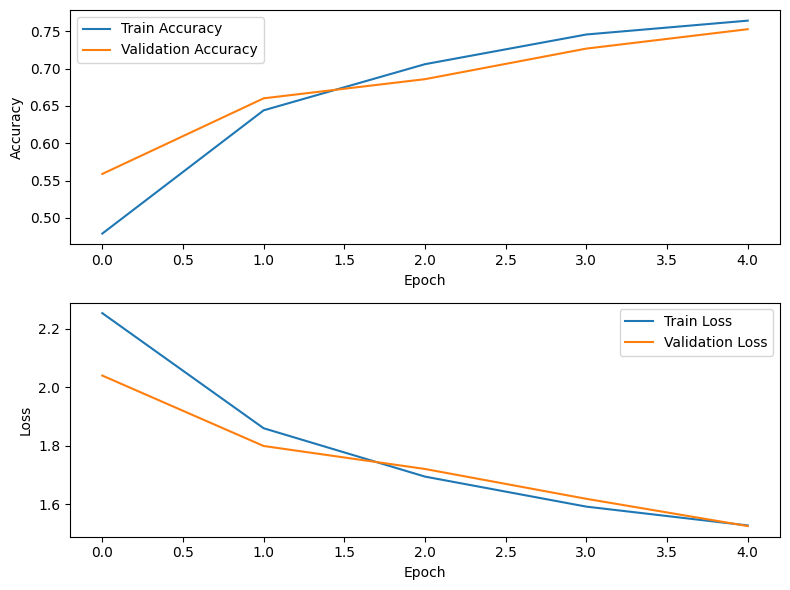

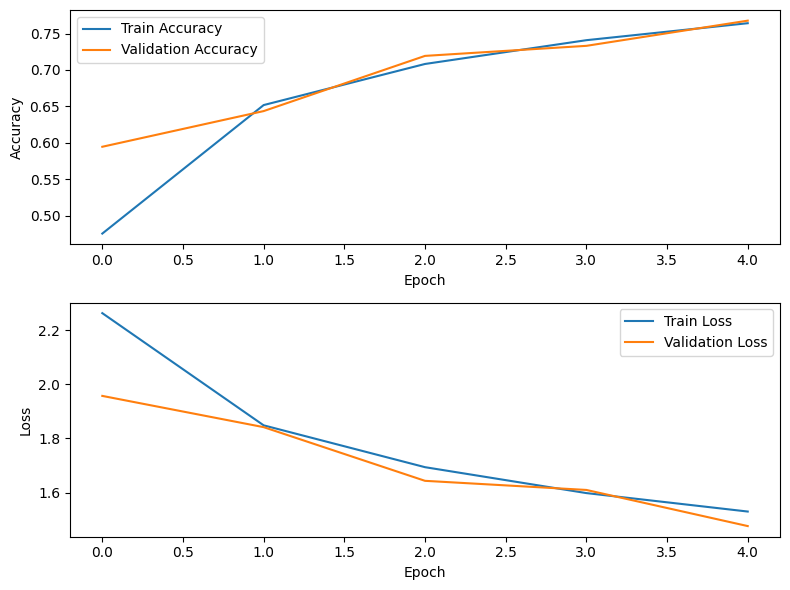

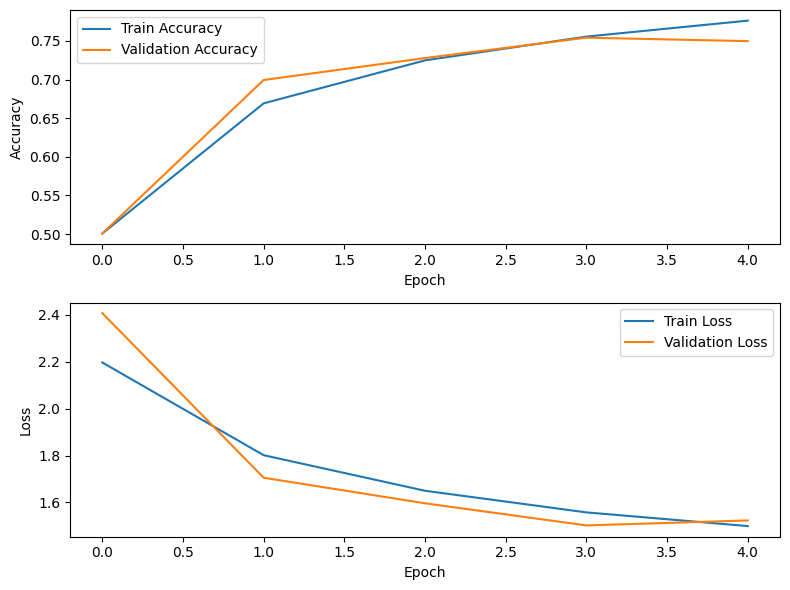

/*-----------------------------*/
/*         iteration 2        */
/*----------------------------*/
   * Select parent for crossing:
       - Selection --------------- 100%
   * Offspring:
       - Crossover:
           mask : [1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1]
       - Crossover:
           mask : [0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1]
       - Performing KD on the children :
------------------------------ Training 1 ---------------------------------
Epoch 0/4
----------
train Loss: 2.2437 Acc: 0.4801
val Loss: 2.1191 Acc: 0.5248

Epoch 1/4
----------
train Loss: 1.8681 Acc: 0.6436
val Loss: 1.6995 Acc: 0.6887

Epoch 2/4
----------
train Loss: 1.6949 Acc: 0.7079
val Loss: 1.6662 Acc: 0.7080

Epoch 3/4
----------
train Loss: 1.6042 Acc: 0.7401
val Loss: 1.6844 Acc: 0.7085

Epoch 4/4
----------
train Loss: 1.5398 Ac

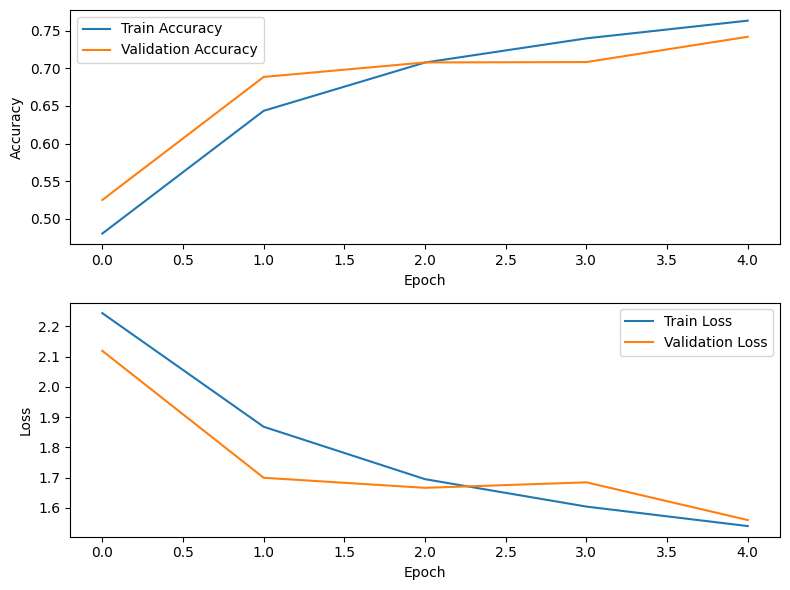

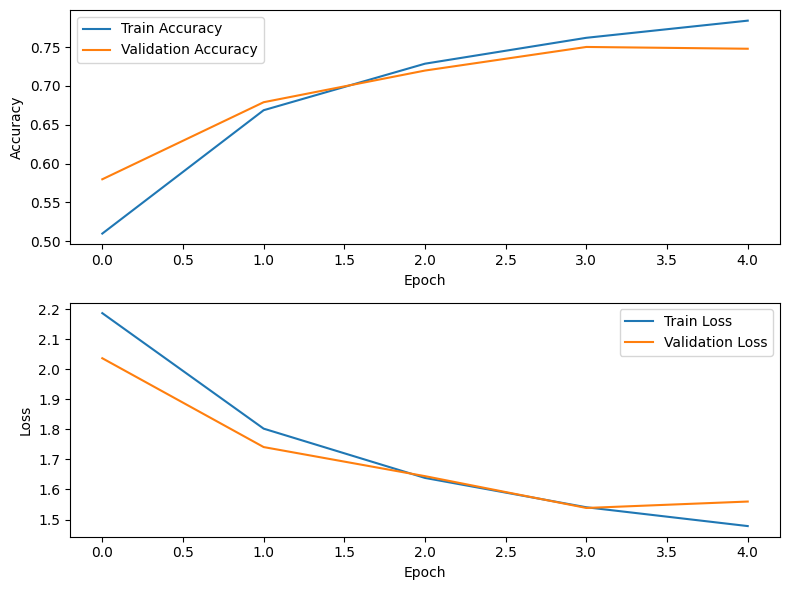

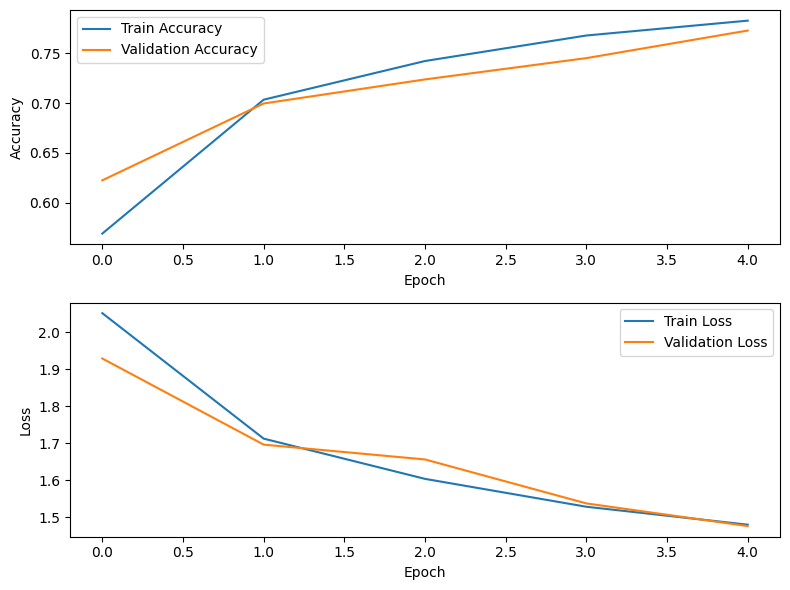

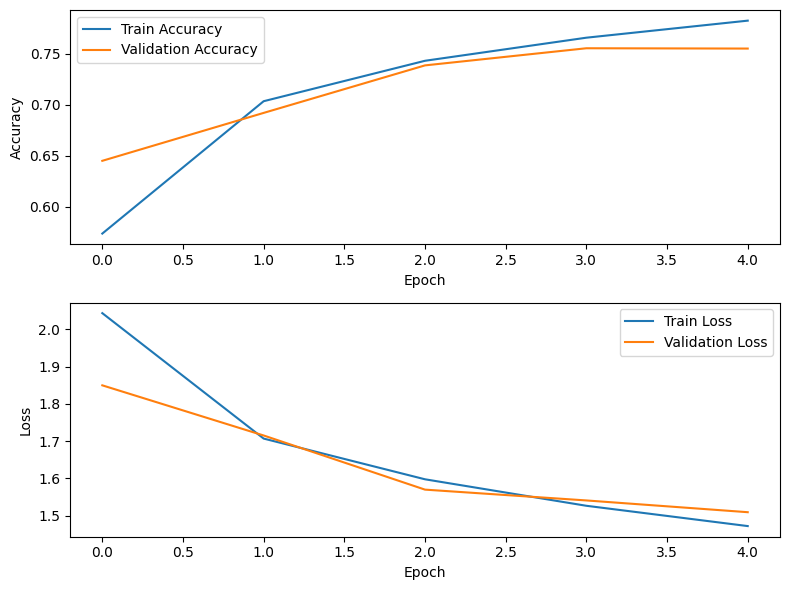

Select the winning ticket from final population
  - Selection --------------- 100%


In [ ]:
winning_ticket = AG.AG_method(model_base, save_to, nb_itr = 2, N = 8 ,pruning_rate = 0.85, pruning_space = 0.05,kd_epoch = 5)

## Evaluate the winning ticket

In [ ]:
save_to = '/content/drive/Shareddrives/PFE 22 23 Feliachi et Frioui/..Tests/Cifar-10/ResNet18/'
winning_ticket = torch.load( save_to + 'winning_ticket')

In [ ]:
AG.calculate_sparsity(winning_ticket)

tensor(0.8630, device='cuda:0')

In [ ]:
AG.evaluation_2(winning_ticket, nn.CrossEntropyLoss())

Accuracy: 76.77%
Loss: 0.8575


(0.7677, 0.857459919562765)

In [ ]:
data = AG.dataloaders['val']
for in_ , lbl in data:
  in_ = in_.to(AG.device)
  lbl = lbl.to(AG.device)
  out = winning_ticket(in_)
  _, preds = torch.max(out, 1)
  print(preds)
  print('-'*10)
  print(lbl)
  print('-'*10)
  print(preds-lbl)
  break

tensor([3, 5, 1, 3, 1, 4, 0, 4, 4, 0, 9, 5, 8, 9, 8, 3, 8, 5, 9, 5, 1, 3, 8, 7,
        4, 8, 0, 4, 6, 7, 9, 4, 9, 7, 4, 3, 0, 1, 5, 8, 5, 9, 6, 2, 1, 0, 4, 1,
        2, 0, 5, 6, 4, 3, 8, 6, 1, 0, 3, 3, 3, 4, 6, 8], device='cuda:0')
----------
tensor([3, 5, 1, 5, 8, 4, 0, 3, 4, 0, 9, 5, 8, 1, 8, 3, 8, 5, 9, 3, 1, 2, 4, 7,
        4, 9, 0, 4, 6, 7, 0, 5, 9, 7, 4, 3, 0, 1, 5, 8, 5, 9, 6, 2, 9, 0, 4, 9,
        2, 7, 5, 6, 3, 7, 8, 6, 1, 0, 3, 5, 2, 4, 4, 8], device='cuda:0')
----------
tensor([ 0,  0,  0, -2, -7,  0,  0,  1,  0,  0,  0,  0,  0,  8,  0,  0,  0,  0,
         0,  2,  0,  1,  4,  0,  0, -1,  0,  0,  0,  0,  9, -1,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0, -8,  0,  0, -8,  0, -7,  0,  0,  1, -4,
         0,  0,  0,  0,  0, -2,  1,  0,  2,  0], device='cuda:0')


## Fine-tune the winning ticket

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(winning_ticket.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.1)
winning_ticket, statics = train_model(winning_ticket, criterion , optimizer_conv , exp_lr_scheduler , 10)

Epoch 0/9
----------
train Loss: 0.7026 Acc: 0.7573
val Loss: 0.6778 Acc: 0.7644

Epoch 1/9
----------
train Loss: 0.6041 Acc: 0.7891
val Loss: 0.7526 Acc: 0.7390

Epoch 2/9
----------
train Loss: 0.5541 Acc: 0.8076
val Loss: 0.6451 Acc: 0.7778

Epoch 3/9
----------
train Loss: 0.5175 Acc: 0.8189
val Loss: 0.6781 Acc: 0.7702

Epoch 4/9
----------
train Loss: 0.4889 Acc: 0.8310
val Loss: 0.6514 Acc: 0.7740

Epoch 5/9
----------
train Loss: 0.3707 Acc: 0.8740
val Loss: 0.5371 Acc: 0.8177

Epoch 6/9
----------
train Loss: 0.3332 Acc: 0.8890
val Loss: 0.5423 Acc: 0.8170

Epoch 7/9
----------
train Loss: 0.3134 Acc: 0.8945
val Loss: 0.5407 Acc: 0.8191

Epoch 8/9
----------
train Loss: 0.3041 Acc: 0.8975
val Loss: 0.5505 Acc: 0.8190

Epoch 9/9
----------
train Loss: 0.2911 Acc: 0.9028
val Loss: 0.5523 Acc: 0.8145

Training complete in 38m 39s
Best val Acc: 0.819100


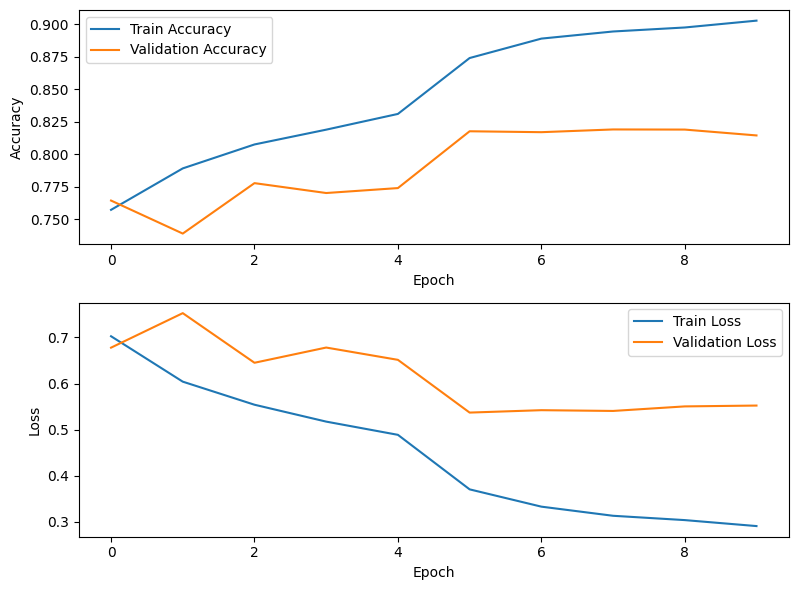

In [ ]:
AG.show_statics_training(statics,save_to + 'winning_ticket')
torch.save(winning_ticket, save_to + 'winning_ticket')

In [ ]:
AG.evaluation_2(winning_ticket, nn.CrossEntropyLoss())

Accuracy: 81.91%
Loss: 0.5409


(0.8191, 0.5409282569293004)